In [62]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from src.config import PROCESSED_DATA_DIR

processed_train_path: Path = PROCESSED_DATA_DIR / "trainset.csv"
processed_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"

df_train = pd.read_csv(str(processed_train_path), index_col='id')
df_test = pd.read_csv(str(processed_test_path), index_col= 'id')

X_train, y_train = df_train.drop(columns=['r_spread']), df_train.loc[:,'r_spread']
X_test, y_test = df_test.drop(columns=['r_spread']), df_test.loc[:,'r_spread']


In [24]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)


RandomForestRegressor()

In [25]:
processed_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"
df_test = pd.read_csv(str(processed_test_path), index_col= 'id')

X_test, y_test = df_test.drop(columns=['r_spread']), df_test.loc[:,'r_spread']

In [26]:
rfr.score(X_test, y_test)

0.010533868226157983

In [27]:
#202201160kan
X_test.loc['202201160kan']

temperature       30.0000
humidity_pct      78.0000
wind_speed         8.0000
week              19.0000
tm_first_downs    24.3125
                   ...   
week_day_Sat       0.0000
week_day_Sun       1.0000
week_day_Thu       0.0000
week_day_Tue       0.0000
week_day_Wed       0.0000
Name: 202201160kan, Length: 167, dtype: float64

In [28]:
rfr.predict(X_test.loc[['202201160kan', '202211270was', '202309170tam']])

array([10.78,  3.26,  9.17])

In [29]:
y_test.loc[['202201160kan', '202211270was', '202309170tam']]

id
202201160kan    21
202211270was     6
202309170tam    10
Name: r_spread, dtype: int64

In [30]:
import joblib
from src.config import MODELS_DIR

rfrv1_output_path = MODELS_DIR / "rfr_v1.0.0.pkl"
joblib.dump(rfr, rfrv1_output_path) 

['G:\\Work\\DS\\dont-bet-on-sports\\models\\rfr_v1.0.0.pkl']

### Neural Network with PyTorch

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


class NFLPredictor(nn.Module):
    def __init__(self):
        super(NFLPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.LeakyReLU(negative_slope=0.03),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),  # Dropout layer with 30% probability
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = NFLPredictor()
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=32,
    shuffle=True
)

epochs = 600
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        model.train()
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()
        scheduler.step(loss)

"\n# Training loop\nepochs = 100\nfor epoch in range(epochs):\n    model.train()\n    optimizer.zero_grad()\n    \n    # Forward pass\n    outputs = model(X_train_tensor)\n    loss = criterion(outputs, y_train_tensor)\n    \n    # Backward pass and optimization\n    loss.backward()\n    optimizer.step()\n    \n    # Step the scheduler\n    scheduler.step(loss)\n\n    if (epoch + 1) % 10 == 0:\n        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')\n"

In [67]:
from sklearn.metrics import mean_absolute_error as mae 

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 10.8231


In [77]:
# Example prediction on new unseen data
new_data_scaled = torch.tensor([X_test.loc[['202309170tam']].to_numpy()], dtype=torch.float32)
results = None
with torch.no_grad():
    results = model(X_test_tensor)


In [78]:
import matplotlib.pyplot as plt
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR

int_test_path : Path = INTERIM_DATA_DIR / "testset.csv"
df_int = pd.read_csv(str(int_test_path), index_col='id')
df_pred = pd.DataFrame({'r_spread': df_test['r_spread'].values.tolist(), 'pred': results.flatten().tolist(), 'spread_line': df_int['tm_spread'].values.tolist()})

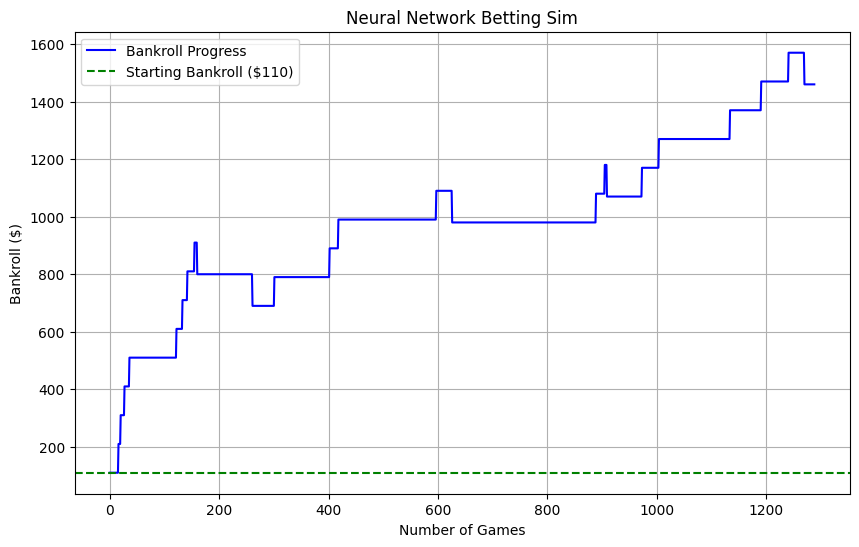

In [90]:
# Initialize variables for bankroll and profit/loss
initial_bankroll = 110  # Starting with $100
current_bankroll = initial_bankroll
wager_amount = 110  # Wager $110 per bet to win $100

# Initialize a list to store bankroll after each bet
bankroll_progress = []

# Loop through each row to simulate the bets
for index, row in df_pred.iterrows():
    actual_r_spread = row['r_spread']
    prediction = row['pred']
    spread_line = row['spread_line']
    
    # Betting strategy: Bet on the team if pred > spread_line (predicting the team will cover the spread)
    if spread_line < 0 and (prediction - abs(spread_line)) > 0:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        if actual_r_spread > abs(spread_line):
            current_bankroll += 100  # Win $100
        else:
            current_bankroll -= wager_amount  # Lose $110 due to vigorish (110)
    elif spread_line > 0 and (abs(prediction) - spread_line) > 0:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        if abs(actual_r_spread) > spread_line:
            current_bankroll += 100  # Win $100
        else:
            current_bankroll -= wager_amount  # Lose $110 due to vigorish (110)

    # Append the current bankroll to the list for tracking progress
    bankroll_progress.append(current_bankroll)

# Add the bankroll progress to the DataFrame for visualization
df_pred['bankroll'] = bankroll_progress

# Plot the bankroll progression over time (as bets progress)
plt.figure(figsize=(10, 6))
plt.plot(df_pred['bankroll'], label='Bankroll Progress', color='b')
plt.axhline(initial_bankroll, color='green', linestyle='--', label='Starting Bankroll ($110)')
plt.title('Neural Network Betting Sim')
plt.xlabel('Number of Games')
plt.ylabel('Bankroll ($)')
plt.legend()
plt.grid(True)
plt.show()
